We will begin by downloading the data set

In [5]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sbn

auto_data = pd.read_csv(fileName)
print(auto_data.head())
print(auto_data.dtypes)

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compressi

I will replace the ? with the mean value

In [6]:
##auto_data['price'] = auto_data['price'].replace('?', np.NaN)
auto_data['price']= auto_data['price'].replace(to_replace = "?", value = float("NaN"))
auto_data['price'] = pd.to_numeric(auto_data['price'], errors ='coerce')
price_out = np.isnan(auto_data['price'])
freemean = np.nanmean(auto_data['price'], axis = 0)
auto_data['price']= auto_data['price'].replace(to_replace = float("NaN"), value = freemean)
##auto_data['price'] = auto_data[price_out,'price']= freemean
##print(auto_data['price'].value_counts())
print(freemean)
##auto_data['zoom'] = auto_data['zoom'].replace("nan", freemean)
##print(auto_data['price'].unique())


13207.129353233831


Now I will compare the data in the price to a normal distribution. I will first normalize the price 

Text(0.5, 1.0, 'Q-Q plot of Normal distribution versus normed Price distribution')

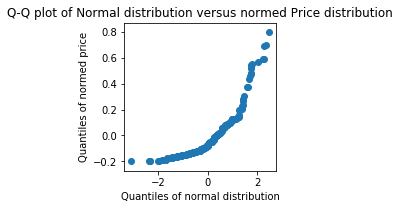

In [7]:
price = auto_data.loc[:,'price']
price_norm = (price - price.mean()) / (price.max() - price.min())
norm1 = nr.normal(size = len(price_norm)).tolist()
plt.figure(figsize=(6, 6)).gca() # define axis
ax1 = plt.subplot(221) 
##plotty = ss.probplot(price_norm, plot = ax1)
##plt.show()## Plot the right subplot
plt.scatter(x = sorted(norm1), y = sorted(price_norm))
plt.xlabel('Quantiles of normal distribution')
plt.ylabel('Quantiles of normed price')
plt.title('Q-Q plot of Normal distribution versus normed Price distribution')
##print(price.unique())

This does not look like a Q-Q plot for a normal distribution versus another normal distribution. Let's do the Kolmogorov-Smirnov test and confirm numerically.

In [9]:
from sklearn.preprocessing import scale
%matplotlib inline
norm1 = nr.normal(size = len(price_norm)).tolist()
price_norm_s = scale(price_norm)
print("the minimum normed price is ", price_norm.min())
print("the maximum normed price is ",price_norm.max())
print("the mean normed price of is ", price_norm.mean())
print("the standard deviation of the normed price is",price_norm.std())

plt_cums(norm1, price_norm_s) 
##def ks_test(dat, dist = 'norm'):
##    from scipy.stats import kstest 
##    ks_statisic, pvalue = kstest(dat, dist)
##    print('KS-statistic = ' + str(ks_statisic))
##    print('P-value = ' + str(pvalue))
##ks_test(price_norm_s)  
##print(price_norm.value_counts())
##print(price_norm.unique())
print("The KS test result and the p value are", ss.kstest(price_norm, 'norm'))

the minimum normed price is  -0.20081250566590117
the maximum normed price is  0.7991874943340989
the mean normed price of is  -1.3945484333706235e-17
the standard deviation of the normed price is 0.1953420438991063


NameError: name 'plt_cums' is not defined

The k-statistic is high, and the p-value is 0 - so <b>we can reject the Null hypothesis that the two distributions (normed price and a normal distribution) are the same type</b>. 


Now let's look at the log of price

Text(0.5, 1.0, 'Q-Q plot of Normal distribution versus normed log of  Price distribution')

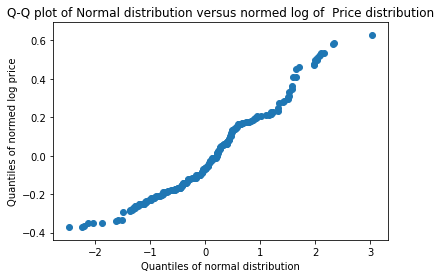

In [64]:
log_price = np.log(price)
auto_data['log price'] = log_price
log_price_norm = (log_price - log_price.mean()) / (log_price.max() - log_price.min())
plt.scatter(x = sorted(norm1), y = sorted(log_price_norm))
plt.xlabel('Quantiles of normal distribution')
plt.ylabel('Quantiles of normed log price')
plt.title('Q-Q plot of Normal distribution versus normed log of  Price distribution')
##print(log_price_norm.value_counts())

The curve looks close to a straight line, but there is "some" difference

the mean of the normed log price is  1.971322833968571e-15
the standard deviation of the normed log price is  0.22800298367529123
KstestResult(statistic=0.0920981305795644, pvalue=0.057912340878556456)


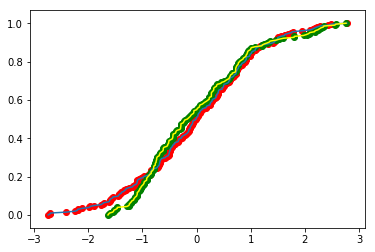

In [65]:
norm2_s = nr.normal(size = len(log_price_norm)).tolist()
log_price_norm_s = scale(log_price_norm)
plot_cums(norm2_s, log_price_norm_s) 
print("the mean of the normed log price is ", log_price_norm.mean())
print("the standard deviation of the normed log price is ",log_price_norm.std())
print(ss.kstest(log_price_norm_s, 'norm'))

The p-value is close to 0.05 and the k-stastic is kinda small and close to 0 - but <b>we can reject the Null hypothesis that the two distribtions are the same type.</b>

<b>For work on the rest of the assignment I will use the normed log of the price since it is close to a normal distribution - certainly closer than the price normed.</b>

In [66]:
auto_data['log price']= log_price_norm
fuel_type = auto_data.groupby('fuel-type')
fuel_typez = pd.DataFrame({'count': fuel_type.size(), 
                       'mean': fuel_type.aggregate(np.mean).loc[:, 'log price']})
print(fuel_typez.head())


           count      mean
fuel-type                 
diesel        20  0.093737
gas          185 -0.010134


There are sufficient data points in both sides that we will run a standard t-test.

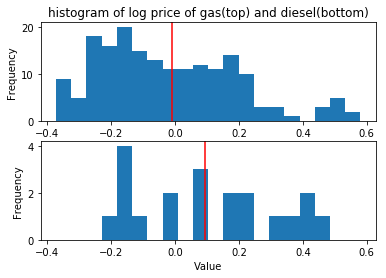

In [67]:
auto_data.loc[:,"gas"] = auto_data.loc[:,"fuel-type"].isin(['gas']).astype(int)
auto_data.loc[:,"diesel"] = auto_data.loc[:,"fuel-type"].isin(['diesel']).astype(int)
auto_gas = auto_data.query('gas == 1')
auto_diesel = auto_data.query('diesel == 1')
def hist_plot(vec, bins):
    from statistics import mean
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
    
def plot_pop(a, b, c, nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title(c)
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

plot_pop(auto_gas.loc[:,"log price"], auto_diesel.loc[:,"log price"],'histogram of log price of gas(top) and diesel(bottom)')  


We can see that there are different means. Let's look at the t-test results below.

In [68]:
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

test = t_test(auto_gas.loc[:,"log price"],auto_diesel.loc[:,"log price"], 0.05)
print(test)

DegFreedom    23.430594
Difference    -0.103871
Statistic     -1.948658
PValue         0.052714
Low95CI       -0.212778
High95CI       0.005036
dtype: float64


This is above our p-value of 0.05 - hence <b>we do not reject the null hypothesis that the two distributions have no significant difference in means</b>.

We will now look at the aspirations and see if there is a sigfinicant difference in means.

In [69]:
auto_aspiration = auto_data.groupby('aspiration')
auto_aspy = pd.DataFrame({'count': auto_aspiration.size(), 
                       'mean': auto_aspiration.aggregate(np.mean).loc[:, 'log price']})
print(auto_aspy.head())



            count      mean
aspiration                 
std           168 -0.027183
turbo          37  0.123424


There are sufficient data points in both sides that we will run a standard t-test.

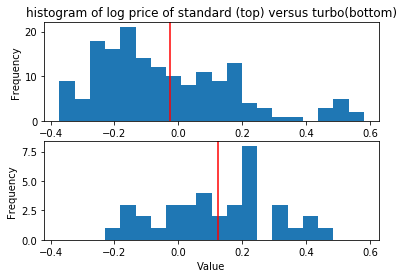

In [70]:
auto_data.loc[:,"standard"] = auto_data.loc[:,"aspiration"].isin(['std']).astype(int)
auto_data.loc[:,"turbo"] = auto_data.loc[:,"aspiration"].isin(['turbo']).astype(int)
auto_standard = auto_data.query('standard == 1')
auto_turbo = auto_data.query('turbo == 1')


plot_pop(auto_standard.loc[:,"log price"], auto_turbo.loc[:,"log price"],'histogram of log price of standard (top) versus turbo(bottom)')  

We see that the means are different. Let's run the t-test to see if it is significant.

In [71]:
test = t_test(auto_standard.loc[:,"log price"],auto_turbo.loc[:,"log price"], 0.05)
print(test)

DegFreedom    67.122761
Difference    -0.150606
Statistic     -3.752098
PValue         0.000229
Low95CI       -0.217634
High95CI      -0.083579
dtype: float64


The p-value is low, and the 95% confidence interval does NOT contain 0 - so we can reject the NULL hypothesis that the means are the same.  The difference in log price is <b>significant for aspiration</b>.


We will now look at rear versus front wheel drive and see if there is a significant difference in means.

In [72]:
print(auto_data.loc[:,"drive-wheels"].unique())
auto_wheels = auto_data.groupby('drive-wheels')
auto_wheelz = pd.DataFrame({'count': auto_wheels .size(), 
                       'mean': auto_wheels .aggregate(np.mean).loc[:, 'log price']})
print(auto_wheelz.head())

['rwd' 'fwd' '4wd']
              count      mean
drive-wheels                 
4wd               9 -0.056705
fwd             120 -0.122935
rwd              76  0.200822


The 4 wheel drive number is small and was not requested, so I will only compare front wheel drive and rear wheel drive means.

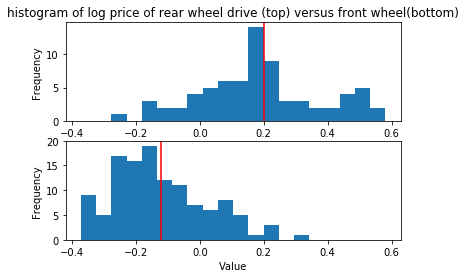

In [73]:
auto_data.loc[:,"fwd"] = auto_data.loc[:,"drive-wheels"].isin(['fwd']).astype(int)
auto_data.loc[:,"rwd"] = auto_data.loc[:,"drive-wheels"].isin(['rwd']).astype(int)
auto_rwd = auto_data.query('rwd == 1')
auto_fwd = auto_data.query('fwd == 1')


plot_pop(auto_rwd.loc[:,"log price"], auto_fwd.loc[:,"log price"],'histogram of log price of rear wheel drive (top) versus front wheel(bottom)')  

The means look different, let's see if it is significant.



In [74]:
test = t_test(auto_fwd.loc[:,"log price"],auto_rwd.loc[:,"log price"], 0.05)
print(test)

DegFreedom    1.258500e+02
Difference   -3.237571e-01
Statistic    -1.303811e+01
PValue        2.577144e-28
Low95CI      -3.763257e-01
High95CI     -2.711885e-01
dtype: float64


The low and high 95% confidence levels do not include 0, and the p-value is very small, hence we can reject the NULL hypothesis that the means are the same.  The difference in log price is <b>significant for drive wheels</b>.


Now let's look at the body styles and run the ANOVA. So .. how many body styles are there and what are they?

In [87]:
print(auto_data.loc[:,"body-style"].unique())
print(auto_data.loc[:,"body-style"].unique())
auto_styles = auto_data.groupby('body-style')
auto_stylez = pd.DataFrame({'count': auto_styles.size(), 
                       'mean': auto_styles.aggregate(np.mean).loc[:, 'log price']})
print(auto_stylez.head())

['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
             count      mean
body-style                  
convertible      6  0.246351
hardtop          8  0.202072
hatchback       70 -0.098405
sedan           96  0.039779
wagon           25 -0.001003


Let's look at the normed log of the price versus the body styles

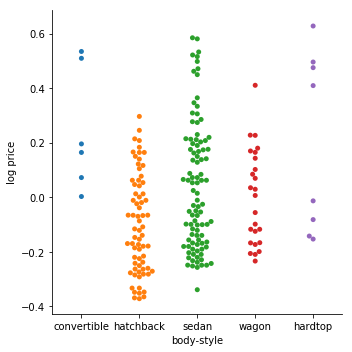

In [83]:
sbn.catplot(x = 'body-style', y = 'log price', kind = 'swarm', data = auto_data)

It looks like there is some significance in the body type.

Let's run the ANOVA and see what we see.

In [103]:
auto_data.loc[:,"convertible"] = auto_data.loc[:,"body-style"].isin(['convertible']).astype(int)
conv = auto_data.query('convertible == 1')
convy = conv.loc[:,"log price"]
auto_data.loc[:,"hatchback"] = auto_data.loc[:,"body-style"].isin(['hatchback']).astype(int)
hatch = auto_data.query('hatchback == 1')
hatchy = hatch.loc[:,"log price"]
auto_data.loc[:,"sedan"] = auto_data.loc[:,"body-style"].isin(['sedan']).astype(int)
sedan = auto_data.query('sedan == 1')
sedany = sedan.loc[:,"log price"]
auto_data.loc[:,"wagon"] = auto_data.loc[:,"body-style"].isin(['wagon']).astype(int)
wagon = auto_data.query('wagon == 1')
wagy = wagon.loc[:,"log price"]
auto_data.loc[:,"hardtop"] = auto_data.loc[:,"body-style"].isin(['hardtop']).astype(int)
hard = auto_data.query('hardtop == 1')
hardy = hard.loc[:,"log price"]

f_statistic, p_value = ss.f_oneway(convy, hatchy, sedany, wagy, hardy)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))



F statistic = 8.369083699184879
P-value = 2.913987212650176e-06


The F statistic is large, and the p-value is well below 0.05 - so we can reject the NULL hypothesis that the means of the log of the price does not vary by body type.


Let's now do the Tukey HSD test and see what it says.

In [160]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
deal1 = pd.DataFrame()
one_data = np.zeros(shape=(len(convy),1)) + 1
deal1.loc[:,"val"] = convy
deal1.loc[:,"group_num"] = one_data.astype(int)
two_data = np.zeros(shape=(len(hatchy),1)) + 2
deal2 = pd.DataFrame()
deal2.loc[:,'val'] = hatchy
deal2.loc[:,"group_num"] = two_data.astype(int)
deal = pd.DataFrame()
deal = deal1
deal = deal.append(deal2)
three_data = np.zeros(shape=(len(sedany),1)) + 3
deal3 = pd.DataFrame()
deal3.loc[:,'val'] = sedany
deal3.loc[:,"group_num"] = three_data.astype(int)
deal = deal.append(deal3)
four_data = np.zeros(shape=(len(wagy),1)) + 4
deal4 = pd.DataFrame()
deal4.loc[:,'val'] = wagy
deal4.loc[:,"group_num"] = four_data.astype(int)
deal = deal.append(deal4)
five_data = np.zeros(shape=(len(hardy),1)) + 5
deal5 = pd.DataFrame()
deal5.loc[:,'val'] = hardy
deal5.loc[:,"group_num"] = five_data.astype(int)
deal = deal.append(deal5)

Tukey_HSD = pairwise_tukeyhsd(deal.val, deal.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -0.3448  -0.5943 -0.0952  True 
  1      3    -0.2066  -0.4535  0.0403 False 
  1      4    -0.2474  -0.5141  0.0194 False 
  1      5    -0.0443  -0.3611  0.2726 False 
  2      3     0.1382   0.046   0.2304  True 
  2      4     0.0974  -0.0393  0.2341 False 
  2      5     0.3005   0.0815  0.5194  True 
  3      4    -0.0408  -0.1725  0.091  False 
  3      5     0.1623  -0.0536  0.3782 False 
  4      5     0.2031  -0.0352  0.4414 False 
---------------------------------------------


We can look at the table above say that the mean of the log of the price is significant for 

Convertibles(1) and Hatchbacks(2)
Hatchbacks(2) and Sedans(3)
Hatchbacks(2) and Hardtops(5)

<b>We reject the NULL hypothesis for the above 3 pairs.</b>

We cannot reject the NULL hypothesis for the other permutations of normed log price and body style.



Now let's look at the rest of the data.l;.,


If I understand question 4 and 5 correctly, we should explore the other relationships (not aspiration, fuel type, body style or drive wheels)

They are 'symboling', 'make', 'num-of-doors', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'.


The category data is in symboling, make, number of doors, engine location, number of cylinders. The rest of the data types are essentially numeric.


[3, 1, 2, 0, -1, -2]


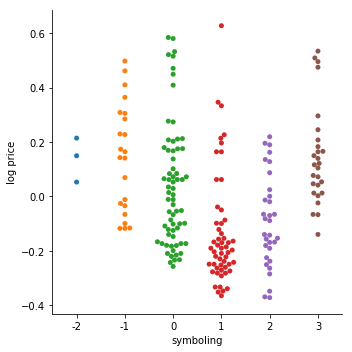

In [163]:
print(list(auto_data.loc[:,"symboling"].unique()))
sbn.catplot(x = 'symboling', y = 'log price', kind = 'swarm', data = auto_data)

Let's look at the symboling and see what we can see from the ANOVA and TukeyHSD tests.

In [164]:
auto_data.loc[:,"neg2"] = auto_data.loc[:,"symboling"].isin(['-2']).astype(int)
neg2 = auto_data.query('neg2 == 1')
neg2y = neg2.loc[:,"log price"]
auto_data.loc[:,"neg1"] = auto_data.loc[:,"symboling"].isin(['-1']).astype(int)
neg1 = auto_data.query('hatchback == 1')
neg1y = neg1.loc[:,"log price"]
auto_data.loc[:,"zed"] = auto_data.loc[:,"symboling"].isin(['0']).astype(int)
zed = auto_data.query('zed == 1')
zedy = sedan.loc[:,"log price"]
auto_data.loc[:,"pos1"] = auto_data.loc[:,"symboling"].isin(['1']).astype(int)
pos1 = auto_data.query('pos1 == 1')
pos1y = wagon.loc[:,"log price"]
auto_data.loc[:,"pos2"] = auto_data.loc[:,"symboling"].isin(['2']).astype(int)
pos2 = auto_data.query('pos2 == 1')
pos2y = pos2.loc[:,"log price"]
auto_data.loc[:,"pos3"] = auto_data.loc[:,"symboling"].isin(['3']).astype(int)
pos3 = auto_data.query('pos3 == 1')
pos3y = pos3.loc[:,"log price"]

f_statistic, p_value = ss.f_oneway(neg2y, neg1y, zedy, pos1y, pos2y, pos3y)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))



F statistic = 8.620474072859201
P-value = 1.5169091980234307e-07


Looks like we can <b>reject the NULL hypothesis that there is no significance in the differences between the means associated with the symboling</b> (even if we don't know what that is).



Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.2374  -0.5752 0.1004 False 
  1      3    -0.0992  -0.4351 0.2367 False 
  1      4     -0.14   -0.4901  0.21  False 
  1      5    -0.2301  -0.5761 0.1158 False 
  1      6     0.0066  -0.3421 0.3553 False 
  2      3     0.1382   0.0481 0.2282  True 
  2      4     0.0974  -0.0361 0.2309 False 
  2      5     0.0073   -0.115 0.1295 False 
  2      6     0.244    0.1142 0.3738  True 
  3      4    -0.0408  -0.1694 0.0879 False 
  3      5    -0.1309  -0.2478 -0.014  True 
  3      6     0.1058   -0.019 0.2306 False 
  4      5    -0.0901   -0.243 0.0628 False 
  4      6     0.1466  -0.0124 0.3056 False 
  5      6     0.2367   0.087  0.3864  True 
--------------------------------------------


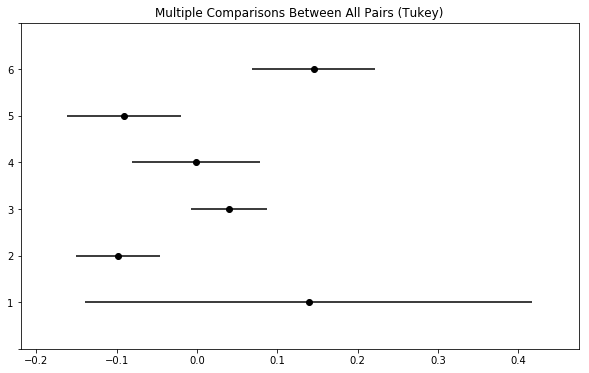

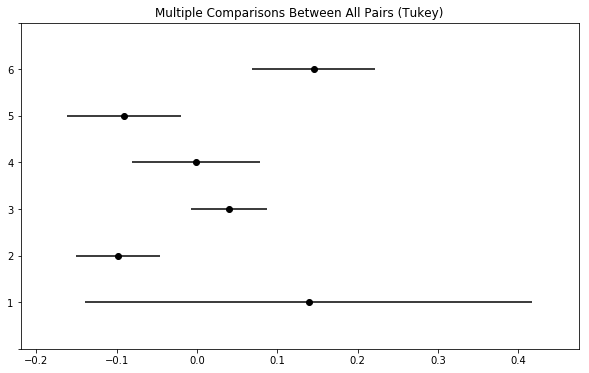

In [180]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
deal1 = pd.DataFrame()
one_data = np.zeros(shape=(len(neg2y),1)) + 1
deal1.loc[:,"val"] = neg2y
deal1.loc[:,"group_num"] = one_data.astype(int)
two_data = np.zeros(shape=(len(neg1y),1)) + 2
deal2 = pd.DataFrame()
deal2.loc[:,'val'] = neg1y
deal2.loc[:,"group_num"] = two_data.astype(int)
deal = pd.DataFrame()
deal = deal1
deal = deal.append(deal2)
three_data = np.zeros(shape=(len(zedy),1)) + 3
deal3 = pd.DataFrame()
deal3.loc[:,'val'] = zedy
deal3.loc[:,"group_num"] = three_data.astype(int)
deal = deal.append(deal3)
four_data = np.zeros(shape=(len(pos1y),1)) + 4
deal4 = pd.DataFrame()
deal4.loc[:,'val'] = pos1y
deal4.loc[:,"group_num"] = four_data.astype(int)
deal = deal.append(deal4)
five_data = np.zeros(shape=(len(pos2y),1)) + 5
deal5 = pd.DataFrame()
deal5.loc[:,'val'] = pos2y
deal5.loc[:,"group_num"] = five_data.astype(int)
deal = deal.append(deal5)
five_data = np.zeros(shape=(len(pos3y),1)) + 6
deal6 = pd.DataFrame()
deal6.loc[:,'val'] = pos3y
deal6.loc[:,"group_num"] = five_data.astype(int)
deal = deal.append(deal6)

Tukey_HSD = pairwise_tukeyhsd(deal.val, deal.group_num)

print(Tukey_HSD)
Tukey_HSD.plot_simultaneous()

Looking at the above, we can reject the null hypothesis for

<b>symbol -1 and symbol 0<br>
symbol -1 and symbol 3<br>
symbol 0 and symbol 2<br>
symbol 2 and symbol 3</b><br>

The rest of the permutations we will not reject the NULL hypothesis.


Now we will look at the data on makes

In [210]:
makes = auto_data.groupby('make')
auto_makes = pd.DataFrame({'count': makes.size(), 
                       'mean': makes.aggregate(np.mean).loc[:, 'log price']})
print(auto_makes)

               count      mean
make                          
alfa-romero        3  0.133450
audi               7  0.174872
bmw                8  0.350273
chevrolet          3 -0.301296
dodge              9 -0.188556
honda             13 -0.169460
isuzu              4 -0.034562
jaguar             3  0.502852
mazda             17 -0.065852
mercedes-benz      8  0.482746
mercury            1  0.164234
mitsubishi        13 -0.123051
nissan            18 -0.082196
peugot            11  0.130549
plymouth           7 -0.185161
porsche            5  0.372767
renault            2 -0.084438
saab               6  0.120341
subaru            12 -0.148760
toyota            32 -0.091254
volkswagen        12 -0.071148
volvo             11  0.198318


[Text(0, 0, 'alfa-romero'),
 Text(0, 0, 'audi'),
 Text(0, 0, 'bmw'),
 Text(0, 0, 'chevrolet'),
 Text(0, 0, 'dodge'),
 Text(0, 0, 'honda'),
 Text(0, 0, 'isuzu'),
 Text(0, 0, 'jaguar'),
 Text(0, 0, 'mazda'),
 Text(0, 0, 'mercedes-benz'),
 Text(0, 0, 'mercury'),
 Text(0, 0, 'mitsubishi'),
 Text(0, 0, 'nissan'),
 Text(0, 0, 'peugot'),
 Text(0, 0, 'plymouth'),
 Text(0, 0, 'porsche'),
 Text(0, 0, 'renault'),
 Text(0, 0, 'saab'),
 Text(0, 0, 'subaru'),
 Text(0, 0, 'toyota'),
 Text(0, 0, 'volkswagen'),
 Text(0, 0, 'volvo')]

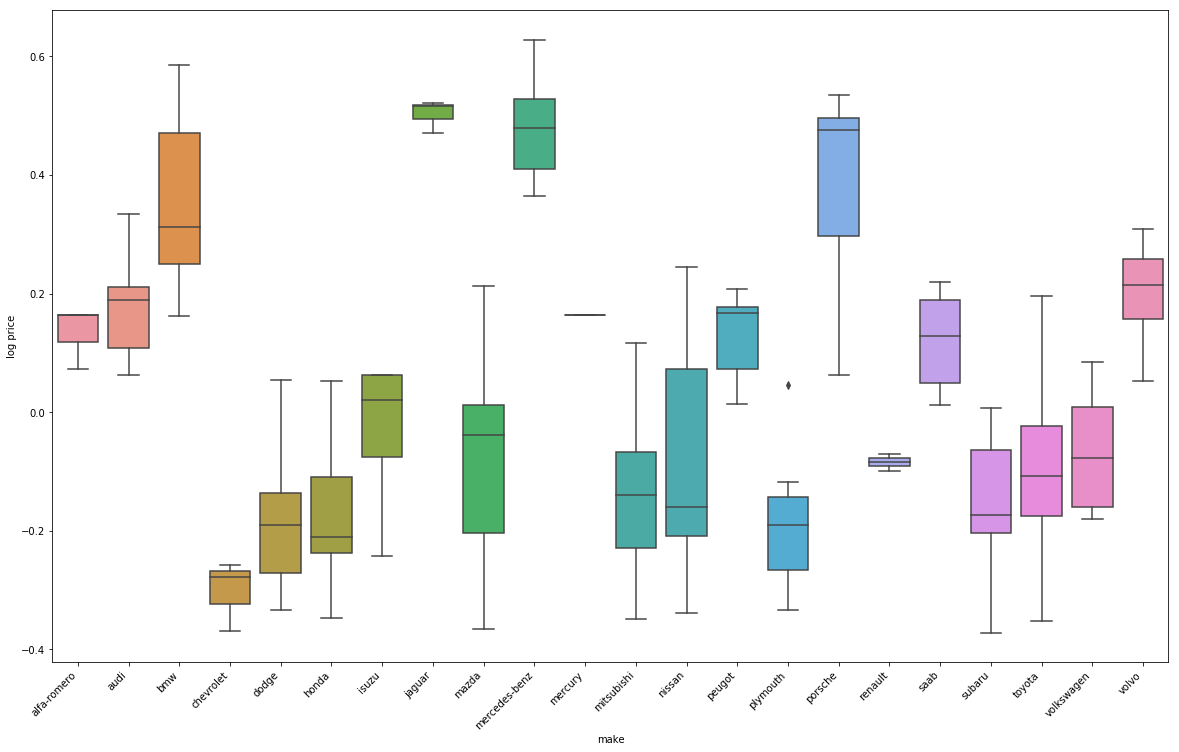

In [190]:
ax1 = plt.figure(figsize=(20, 12)).gca()
g = sbn.boxplot(x = 'make', y = 'log price', data = auto_data, ax = ax1)
##, labels = plt.xticks()
##plt.setp(labels, rotation=45)
g.set_xticklabels(labels, rotation=45, ha = 'right')

<b>It's clear that there is a normed log price difference between makers.</b> 


I will continue with the ANOVA and Tukey analysis, using only makes with 9 or more counts.





In [225]:
auto_data.loc[:,"dodge"] = auto_data.loc[:,"make"].isin(['dodge']).astype(int)
dodge = auto_data.query('dodge == 1')
dodgey = dodge.loc[:,"log price"]
auto_data.loc[:,"honda"] = auto_data.loc[:,"make"].isin(['honda']).astype(int)
honda = auto_data.query('honda == 1')
honday = honda.loc[:,"log price"]
auto_data.loc[:,"mazda"] = auto_data.loc[:,"make"].isin(['mazda']).astype(int)
mazda = auto_data.query('mazda == 1')
mazday = mazda.loc[:,"log price"]
auto_data.loc[:,"mits"] = auto_data.loc[:,"make"].isin(['mitsubishi']).astype(int)
mits = auto_data.query('mits == 1')
mitsy = mits.loc[:,"log price"]
auto_data.loc[:,"nissan"] = auto_data.loc[:,"make"].isin(['nissan']).astype(int)
nissan = auto_data.query('nissan == 1')
nissany = nissan.loc[:,"log price"]
auto_data.loc[:,"peugot"] = auto_data.loc[:,"make"].isin(['peugot']).astype(int)
peugot = auto_data.query('peugot == 1')
peugoty = peugot.loc[:,"log price"]
auto_data.loc[:,"subaru"] = auto_data.loc[:,"make"].isin(['subaru']).astype(int)
subaru = auto_data.query('subaru == 1')
subaruy = subaru.loc[:,"log price"]
auto_data.loc[:,"toyota"] = auto_data.loc[:,"make"].isin(['toyota']).astype(int)
toyota = auto_data.query('toyota == 1')
toyotay = toyota.loc[:,"log price"]
auto_data.loc[:,"volks"] = auto_data.loc[:,"make"].isin(['volkswagen']).astype(int)
volks = auto_data.query('volks == 1')
volksy = volks.loc[:,"log price"]
auto_data.loc[:,"volvo"] = auto_data.loc[:,"make"].isin(['volvo']).astype(int)
volvo = auto_data.query('volvo == 1')
volvoy = volvo.loc[:,"log price"]

f_statistic, p_value = ss.f_oneway(dodgey, honday, mazday, mitsy, nissany, peugoty, subaruy, toyotay, volksy, volvoy)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))




F statistic = 10.12831218589234
P-value = 7.142728997632686e-12


We see that we have a small p-value - <b>so we can reject the NULL hypothesis that there is no signficant difference in the means of the normed log price by make.</b>

Let's perform the TukeyHS test and see for which pairs in particular we can reject the NULL hypothesis

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2     0.1036  -0.0524  0.2596 False 
  1      3     0.0464  -0.1196  0.2125 False 
  1      4     0.0873  -0.0668  0.2414 False 
  1      5      0.3     0.1266  0.4734  True 
  1      6     0.0207  -0.1488  0.1902 False 
  1      7     0.0782   -0.061  0.2174 False 
  1      8     0.0983  -0.0712  0.2678 False 
  1      9     0.3678   0.1943  0.5412  True 
  2      3    -0.0572  -0.2132  0.0988 False 
  2      4    -0.0163  -0.1595  0.1268 False 
  2      5     0.1964   0.0326  0.3602  True 
  2      6    -0.0829  -0.2425  0.0767 False 
  2      7    -0.0254  -0.1525  0.1017 False 
  2      8    -0.0053  -0.1649  0.1543 False 
  2      9     0.2642   0.1003  0.428   True 
  3      4     0.0409  -0.1132  0.1949 False 
  3      5     0.2536   0.0802  0.427   True 
  3      6    -0.0257  -0.1952  0.1438 False 
  3      7     0.0318  -0.107

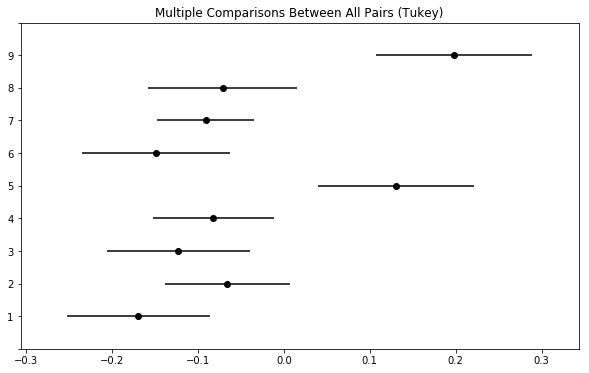

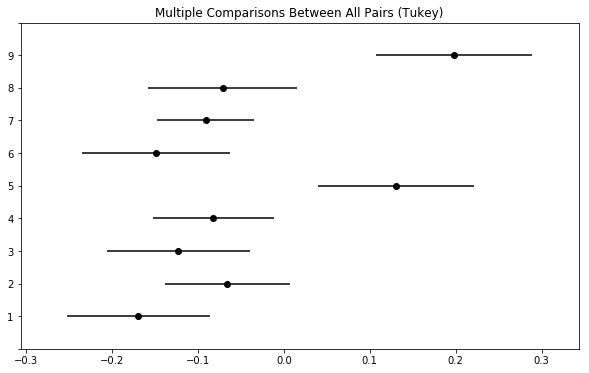

In [227]:
deal1 = pd.DataFrame()
one_data = np.zeros(shape=(len(honday),1)) + 1
deal1.loc[:,"val"] = honday
deal1.loc[:,"group_num"] = one_data.astype(int)
two_data = np.zeros(shape=(len(mazday),1)) + 2
deal2 = pd.DataFrame()
deal2.loc[:,'val'] = mazday
deal2.loc[:,"group_num"] = two_data.astype(int)
deal = pd.DataFrame()
deal = deal1
deal = deal.append(deal2)
three_data = np.zeros(shape=(len(mitsy),1)) + 3
deal3 = pd.DataFrame()
deal3.loc[:,'val'] = mitsy
deal3.loc[:,"group_num"] = three_data.astype(int)
deal = deal.append(deal3)
four_data = np.zeros(shape=(len(nissany),1)) + 4
deal4 = pd.DataFrame()
deal4.loc[:,'val'] = nissany
deal4.loc[:,"group_num"] = four_data.astype(int)
deal = deal.append(deal4)
five_data = np.zeros(shape=(len(peugoty),1)) + 5
deal5 = pd.DataFrame()
deal5.loc[:,'val'] = peugoty
deal5.loc[:,"group_num"] = five_data.astype(int)
deal = deal.append(deal5)
five_data = np.zeros(shape=(len(subaruy),1)) + 6
deal6 = pd.DataFrame()
deal6.loc[:,'val'] = subaruy
deal6.loc[:,"group_num"] = five_data.astype(int)
deal = deal.append(deal6)
six_data = np.zeros(shape=(len(toyotay),1)) + 7
deal7 = pd.DataFrame()
deal7.loc[:,'val'] = toyotay
deal7.loc[:,"group_num"] = six_data.astype(int)
deal = deal.append(deal7)
seven_data = np.zeros(shape=(len(volksy),1)) + 8
deal8 = pd.DataFrame()
deal8.loc[:,'val'] = volksy
deal8.loc[:,"group_num"] = seven_data.astype(int)
deal = deal.append(deal8)
eight_data = np.zeros(shape=(len(volvoy),1)) + 9
deal8 = pd.DataFrame()
deal8.loc[:,'val'] = volvoy
deal8.loc[:,"group_num"] = eight_data.astype(int)
deal = deal.append(deal8)

Tukey_HSD = pairwise_tukeyhsd(deal.val, deal.group_num)

print(Tukey_HSD)
Tukey_HSD.plot_simultaneous()

We can reject the NULL Hypothesis for the make versus normed log price for the following

<b>Honda versus Peugot<br>
    Honda versus Volvo<br>
    Mazda versus Peugot<br>
    Mazda versus Volvo<br>
    Mitsubishi versus Peugot<br>
    Mitsubishi versus Volvo<br>
    Nissan versus Peugot<br>
    Nissan versus Volvo<br>
    Peugot versus Subaru<br>
    Peugot versus Toyota<br>
    Peugot versus Volkswagen<br>
    Subaru versus Volvo<br>
    Toyota versus Volvo<br>
    Volkswagen versus Volvo<br></b>
    
We cannot reject the null hypothesis for the other permutations.



Let's look at number of doors and see if there's a relationship between that and the normed log of the price.

In [193]:
doors = auto_data.groupby('num-of-doors')
auto_doors = pd.DataFrame({'count': doors.size(), 
                       'mean': doors.aggregate(np.mean).loc[:, 'log price']})
print(auto_doors.head())

              count      mean
num-of-doors                 
?                 2 -0.083420
four            114  0.020503
two              89 -0.024388


Let's look at the graphs of the four doors versus two doors

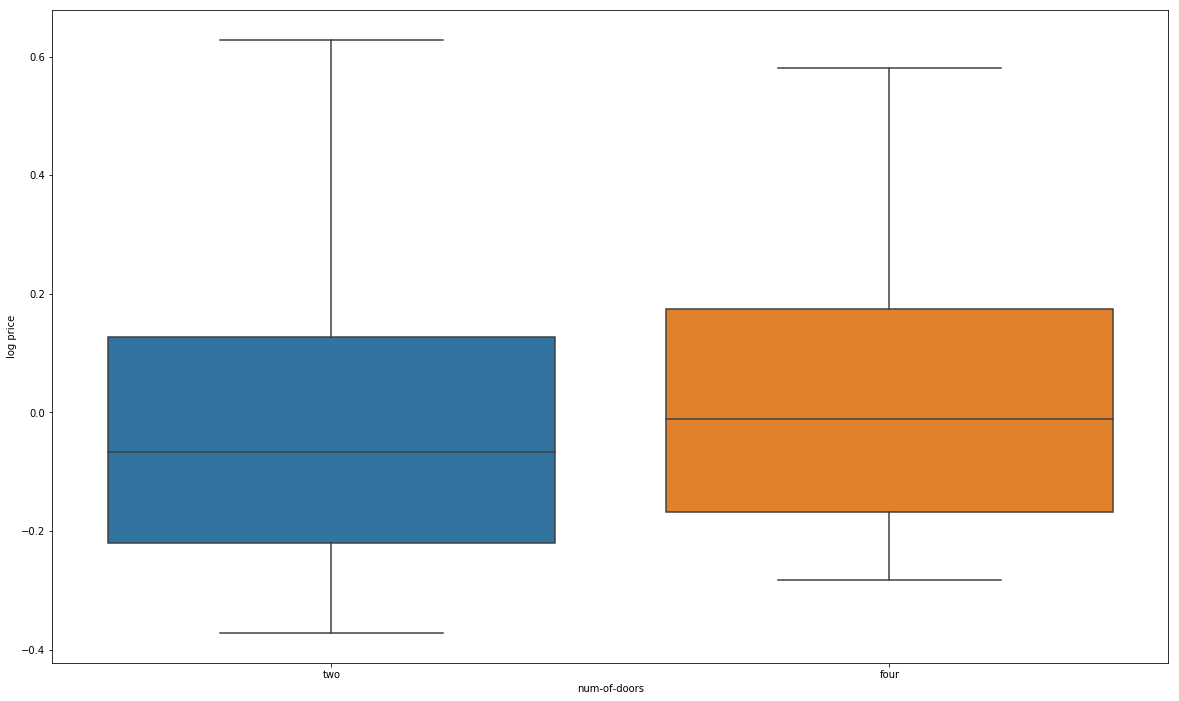

In [206]:
ax1 = plt.figure(figsize=(20, 12)).gca()
trippy = auto_data.loc[auto_data['num-of-doors'] != '?']
sbn.boxplot(x = 'num-of-doors', y = 'log price', data = trippy, ax = ax1)


Let's see if the difference is statistically significant

In [217]:
auto_data.loc[:,"twodoor"] = auto_data.loc[:,"num-of-doors"].isin(['two']).astype(int)
door2 = auto_data.query('twodoor == 1')
door2y = door2.loc[:,"log price"]
auto_data.loc[:,"fourdoor"] = auto_data.loc[:,"num-of-doors"].isin(['four']).astype(int)
fourdoor = auto_data.query('fourdoor == 1')
fourdoory = fourdoor.loc[:,"log price"]
test = t_test(door2y,fourdoory, 0.05)
print(test)

DegFreedom    175.433573
Difference     -0.044891
Statistic      -1.389585
PValue          0.166192
Low95CI        -0.109728
High95CI        0.019945
dtype: float64


As can be seen, the difference in means is not statistically significant, <b>so we cannot reject the NULL hypothesis that the difference in means of normed log price is not significant between two door and four door autos.</b>

Now let's look at engine location

In [218]:
eng_loc = auto_data.groupby('engine-location')
eng_locz = pd.DataFrame({'count': eng_loc.size(), 
                       'mean': eng_loc.aggregate(np.mean).loc[:, 'log price']})
print(eng_locz.head())

                 count      mean
engine-location                 
front              202 -0.007452
rear                 3  0.501780


There really isn't enough data to make a comparison between fron and rear engine locations

Let's look at number of cylinders and see what's there.

In [219]:
cyls = auto_data.groupby('num-of-cylinders')
cylz = pd.DataFrame({'count': cyls.size(), 
                       'mean': cyls.aggregate(np.mean).loc[:, 'log price']})
print(cylz.head())

                  count      mean
num-of-cylinders                 
eight                 5  0.455597
five                 11  0.258929
four                159 -0.079771
six                  24  0.299989
three                 1 -0.369199


I will exclude the eight and three cylinder vehicles and work on the others. Let's take a look at the box plot

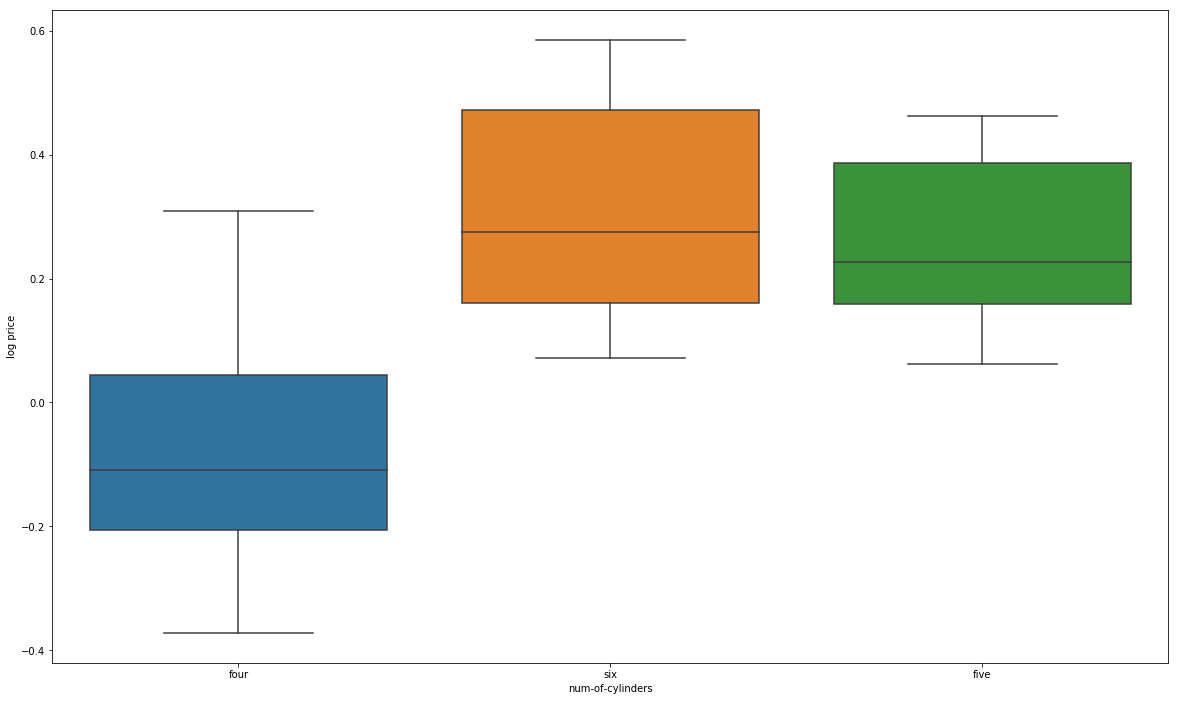

In [222]:
ax1 = plt.figure(figsize=(20, 12)).gca()
auto_data.loc[:,"keepcyl"] = auto_data.loc[:,"num-of-cylinders"].isin(['five', 'four', 'six']).astype(int)
trappy = auto_data.query('keepcyl == 1')
sbn.boxplot(x = 'num-of-cylinders', y = 'log price', data = trappy, ax = ax1)

I'm thinking <b>there's a significant difference in the means of the normed log price versus number of cylinders</b>. 

Let's first do the ANOVA.

In [223]:
auto_data.loc[:,"fourcyl"] = auto_data.loc[:,"num-of-cylinders"].isin(['four']).astype(int)
four = auto_data.query('fourcyl == 1')
foury = four.loc[:,"log price"]
auto_data.loc[:,"fivecyl"] = auto_data.loc[:,"num-of-cylinders"].isin(['five']).astype(int)
five  = auto_data.query('fivecyl == 1')
fivey = five.loc[:,"log price"]
auto_data.loc[:,"sixcyl"] = auto_data.loc[:,"num-of-cylinders"].isin(['six']).astype(int)
six = auto_data.query('sixcyl == 1')
sixy = six.loc[:,"log price"]


f_statistic, p_value = ss.f_oneway(foury, fivey, sixy)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))



F statistic = 73.70436017723559
P-value = 1.8924262176639427e-24


Looks like there is a very low p-value. <b>We can reject the NULL hypothesis regarding number of cylinders and normed log price.</b>

Let's do the TukeyHS

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.3387   0.2193 0.4581  True 
  1      3     0.3798   0.2959 0.4636  True 
  2      3     0.0411  -0.0984 0.1805 False 
--------------------------------------------


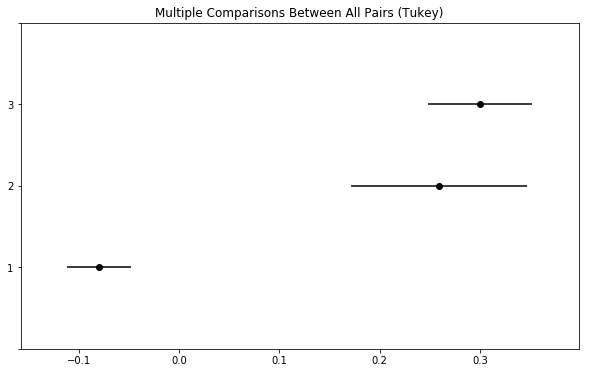

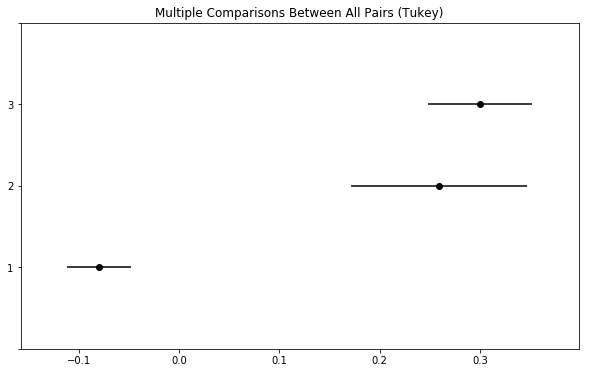

In [224]:
deal1 = pd.DataFrame()
one_data = np.zeros(shape=(len(foury),1)) + 1
deal1.loc[:,"val"] = foury
deal1.loc[:,"group_num"] = one_data.astype(int)
two_data = np.zeros(shape=(len(fivey),1)) + 2
deal2 = pd.DataFrame()
deal2.loc[:,'val'] = fivey
deal2.loc[:,"group_num"] = two_data.astype(int)
deal = pd.DataFrame()
deal = deal1
deal = deal.append(deal2)
three_data = np.zeros(shape=(len(sixy),1)) + 3
deal3 = pd.DataFrame()
deal3.loc[:,'val'] = sixy
deal3.loc[:,"group_num"] = three_data.astype(int)
deal = deal.append(deal3)


Tukey_HSD = pairwise_tukeyhsd(deal.val, deal.group_num)

print(Tukey_HSD)
Tukey_HSD.plot_simultaneous()

We can reject the NULL hypothesis for 

<b>four cylinders versus five cylinders in mean normed log price<br>
four cylinders versus six cylinders in mean novmed log price</b><br>

But we cannot reject the NULL hypothesis for five cylinders versus six cylinders


